## Chapter 10
# Dynamic Spectra

## Gabor's Elementary Signal

Dennis Gabor in the late forties developed an analysis-synthesis model for acoustic signals that combined time domain analysis with the frequency domain analysis of the Fourier transform.

In acoustic analysis (just as in quantum physics), there is an uncertainty tradeoff between time information and frequency information.  The more we know about one, the less we know about the other.  That is, we can't know an instantaneous frequency at an instantaneous time.  We must choose whether we'd prefer to have better temporal resolution and poorer frequency resolution, or vice versa.

If viewed as a rectangle with height of some effective duration $\Delta t$ and  a width of some effective bandwidth $\Delta f$, the _area_ of this rectangle is fixed, but not its _shape_:

$A \geq \Delta t \Delta f$,

where $A$ is the area of the Heisenberg box.

### Acoustical Quanta

Gabor researched windowing functions that could turn the above uncertainty relation into an equality and could therefore be used to represent elementary signals, or _acoustical quanta_.

He proposed using a Gaussian window. Gabor's _elementary signal_ is thus a phasor with a Gaussian envelope:

$s(t) = e^{-\alpha^2(t - t_0)^2}e^{i2\pi ft}$,

where $\alpha$ is a real constant determining the width of the Gaussian window:

In [1]:
import numpy as np

def elementary_signal(alpha, f, t):
    return np.exp(-alpha ** 2 * t ** 2) * np.exp(1j * 2 * np.pi * f * t)

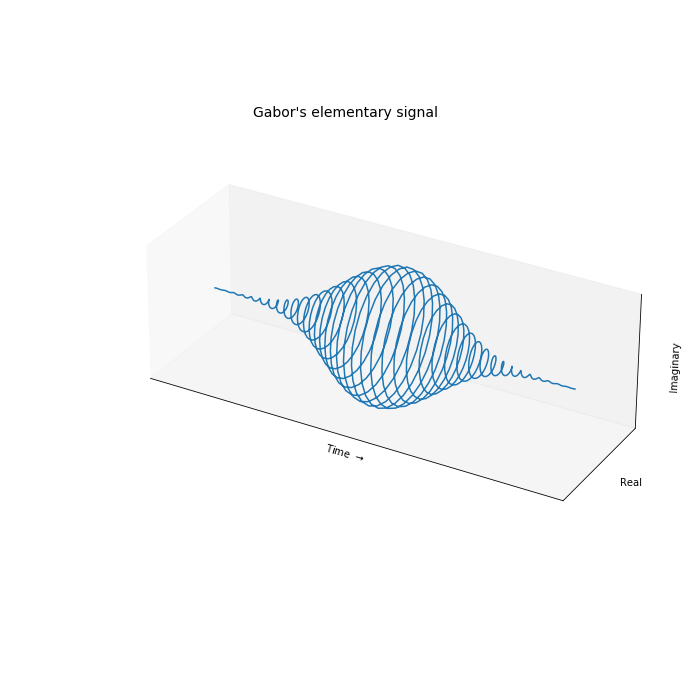

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

def plot_complex_signal(x):
    fig = plt.figure(figsize=(12, 12))
    ax = plt.gca(projection='3d')
    
    ax.plot(np.arange(len(x)), x.real, x.imag)
    ax.set_xlabel('Time $\\rightarrow$')
    ax.set_ylabel('Real')
    ax.set_zlabel('Imaginary')
    
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
    
    x_scale=3; y_scale=1; z_scale=1
    scale=np.diag([x_scale, y_scale, z_scale, 1])
    scale = scale / scale.max()
    scale[3,3] = 0.8 # makes the whole thing larger, apparently ;)
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), scale)
    return ax

ax = plot_complex_signal(elementary_signal(0.5, 4, np.linspace(-5, 5, 1000)))
_ = ax.set_title('Gabor\'s elementary signal', size=14, y=0.90)

_(The above plot is based on **Figure 10.6** on **p458** of the book.)_

## Short-Time Fourier Transform

The short-time Fourier transform takes consecutive snapshots of the frequency spectrum at regular time intervals.  It thus creates a uniform representation of time and frequency.

The formula for the discrete short-time Fourier transform of a signal $x(n)$ is

$X_k(n) = \sum_\limits{r=-\infty}^\limits{\infty}{x(r)h(n-r)e^{-i2\pi kr/N}}$,

where $n$ indexes discrete time for all $-\infty < n < \infty$, $k$ indexes discrete frequency over the range $0 \leq k < N$, and $N$ is the length of the discrete Fourier transform in $n$ (and is also the number of frequency bands into which the spectrum is divided).

The function $h(n)$ is a real-valued discrete-time analysis window defined for all integers $n$. In practice, it is usually equal to zero outside of some central range.

In [3]:
import sys
sys.path.append('../')
from conversion import SAMPLES_PER_SECOND

# returns (frequency_range, time_range, X) (same interface as as np.stft)
# X has time-index columns and row-index frequencies
def stft(x, fs=SAMPLES_PER_SECOND, frame_size_seconds=0.01, hop_size_seconds=0.01):
    frame_samples = int(frame_size_seconds * fs)
    hop_samples = int(hop_size_seconds * fs)
    w = np.hanning(frame_samples)
    X = np.array([np.fft.rfft(w * x[i:i+frame_samples]) for i in range(0, len(x) - frame_samples, hop_samples)])
    return np.fft.rfftfreq(frame_samples, 1/fs), np.linspace(0, len(x) / fs, X.shape[0]), X.T

In [4]:
def plot_stft_3d(x, **args):
    frequencies, times, X = stft(x, **args)
    X = np.abs(X)
    X = X / X.max()
    times, frequencies = np.meshgrid(times, frequencies)
    fig = plt.figure(figsize=(12, 12))
    ax = plt.gca(projection='3d')
    ax.plot_surface(times, frequencies, X, cmap='coolwarm', antialiased=True, rcount=X.shape[1], ccount=X.shape[0])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_zlabel('Magnitude')
    ax.set_title('STFT', y=1.05, size=14)

Let's look at a simple sinusoid with the same frequency over time.

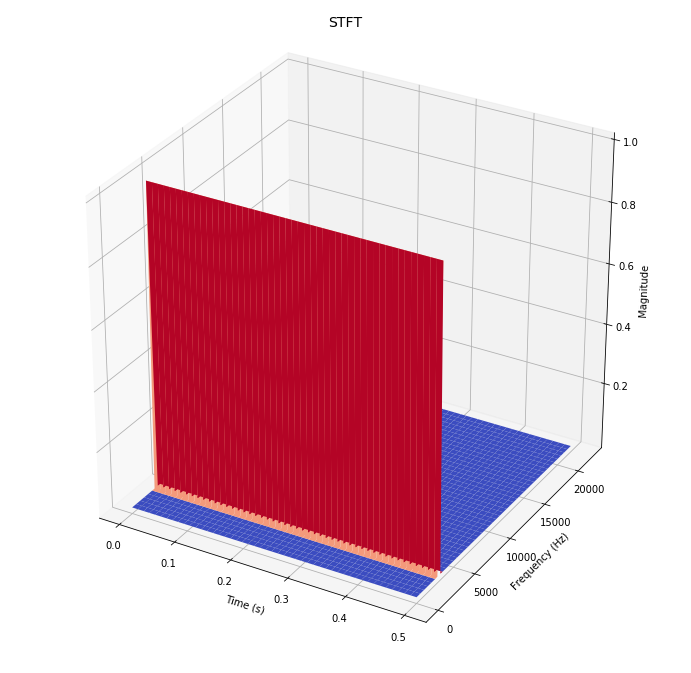

In [5]:
f = 3000
T = 0.5
x = np.sin(2 * np.pi * f * np.linspace(0, T, int(T * SAMPLES_PER_SECOND)))
plot_stft_3d(x)

Now let's add two sinusoids together.

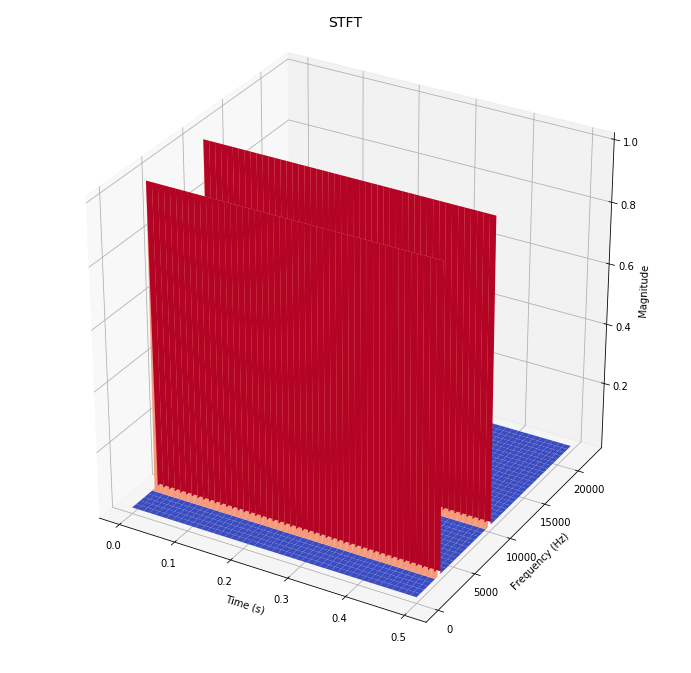

In [6]:
f_1 = 3000
f_2 = 10000
T = 0.5
x = np.sin(2 * np.pi * f_1 * np.linspace(0, T, int(T * SAMPLES_PER_SECOND)))
x += np.sin(2 * np.pi * f_2 * np.linspace(0, T, int(T * SAMPLES_PER_SECOND)))
plot_stft_3d(x)

... a single frequency changing over time:

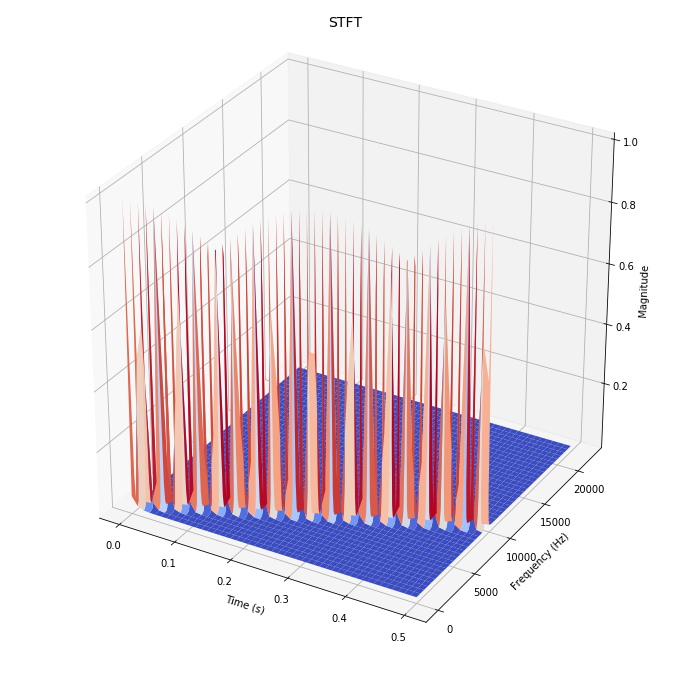

In [7]:
T = 0.5
T_samps = int(T * SAMPLES_PER_SECOND)
x = np.sin(2 * np.pi * np.linspace(100, 5000, T_samps) * np.linspace(0, T, T_samps))
plot_stft_3d(x)

Now let's see a realistic signal (the Amen Break):

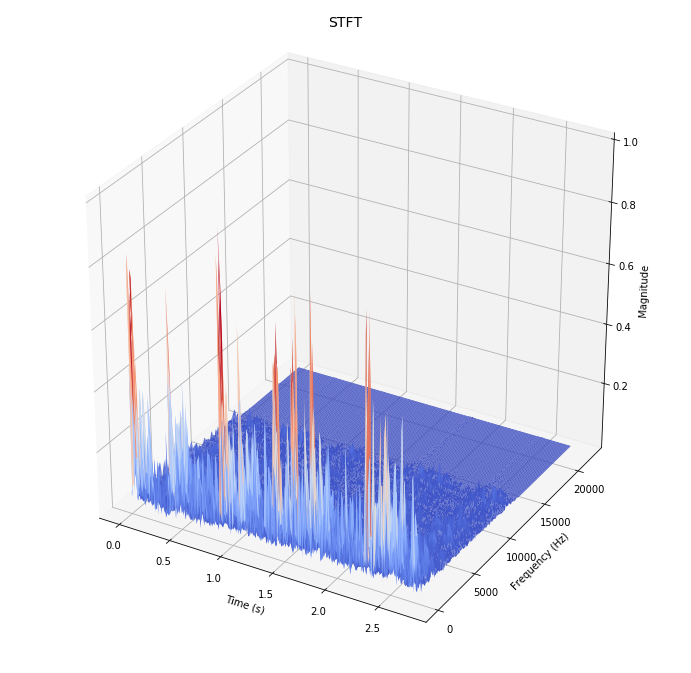

In [8]:
from scipy.io.wavfile import read as readwav
rate, samples = readwav('../amen.wav')
samples = samples[:,0]
plot_stft_3d(samples, frame_size_seconds=0.01, hop_size_seconds=0.01)

Now one with less granular frames:

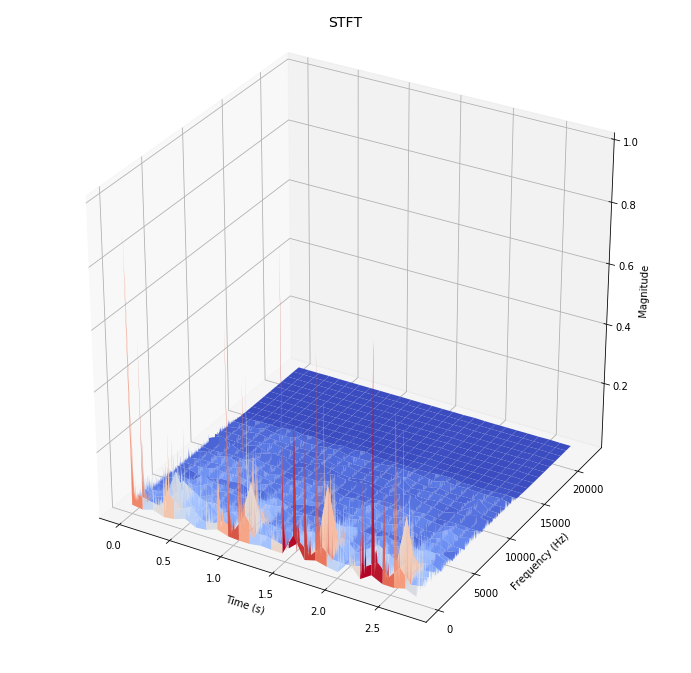

In [9]:
plot_stft_3d(samples, frame_size_seconds=0.1, hop_size_seconds=0.1)

## Inverse STFT

By using an IDFT for each analysis frame and overlapping the analysis windows, we can perfectly reconstruct the original signal.

_The following STFT analysis and resynthesis code was adapted from the [sms-tools](https://github.com/MTG/sms-tools/blob/master/lectures/04-STFT/plots-code/stft-system.py) repo, courtesy of the highly-recommended [Audio Signal Processing for Music Applications](https://www.coursera.org/learn/audio-signal-processing)_ Coursera course.

In [10]:
def dft(x, w, N=1024):
    """
    Analysis of a signal using the discrete Fourier transform
    x: input signal, w: analysis window, N: FFT size 
    returns mX, pX: magnitude and phase spectrum
    """
    fftbuffer = np.zeros(N)
    w = w / sum(w)
    xw = x * w
    # zero-phase window in fftbuffer
    fftbuffer[:(w.size + 1) // 2] = xw[w.size // 2:]
    fftbuffer[-w.size // 2:] = xw[:w.size // 2]        
    X = np.fft.rfft(fftbuffer)
    # for phase calculation set small values to 0
    X.real[np.abs(X.real) < 1e-14] = 0.0
    X.imag[np.abs(X.imag) < 1e-14] = 0.0
    return np.abs(X), np.unwrap(np.angle(X))

def idft(mX, pX, M=1024):
    """
    Synthesis of a signal using the discrete Fourier transform
    mX: magnitude spectrum, pX: phase spectrum, M: window size
    returns y: output signal
    """
    N = (mX.size - 1) * 2
    fftbuffer = np.zeros(N)
    y = np.zeros(M)
    Y = np.zeros(N, dtype=complex)
    # generate positive frequencies
    Y[:mX.size] = mX * np.exp(1j * pX)
    # generate negative frequencies
    Y[mX.size:] = mX[-2:0:-1] * np.exp(-1j * pX[-2:0:-1])
    fftbuffer = np.fft.ifft(Y).real
    y[:M // 2] = fftbuffer[-M // 2:] # undo zero-phase window
    y[M // 2:] = fftbuffer[:(M + 1) // 2]
    return y

def stft(x, w, N=1024, H=512):
    """
    Analysis of a sound using the short-time Fourier transform
    x: input array sound, w: analysis window, N: FFT size, H: hop size
    returns xmX, xpX: magnitude and phase spectra
    """
    M = w.size
    hM1 = (M + 1) // 2
    hM2 = M // 2
    # add zeros at beginning to center first window at sample 0
    # add zeros at the end to analyze last sample
    x = np.pad(x, (hM2,hM2), 'constant', constant_values=0)
    w = w / np.sum(w) # normalize analysis window
    xmX = []
    xpX = []
    for pin in range(hM1, x.size - hM1 + 1, H):
        x1 = x[pin-hM1:pin+hM2]
        mX, pX = dft(x1, w, N)
        xmX.append(np.array(mX))
        xpX.append(np.array(pX))
        pin += H
    return np.array(xmX), np.array(xpX)

def istft(mY, pY, M=1024, H=512):
    """
    Synthesis of a sound using the short-time Fourier transform
    mY: magnitude spectra, pY: phase spectra, M: window size, H: hop-size
    returns y: output sound
    """
    num_frames = mY[:,0].size
    y = np.zeros(num_frames * H + M)
    for i in range(num_frames):
        y1 = idft(mY[i,:], pY[i,:], M)
        y[(i * H):(i * H) + M] += H * y1 # overlap-add
    # delete half of first window which was added in istft
    y = np.delete(y, range(M // 2))
    # delete the end of the sound that was added in istft
    y = np.delete(y, range(y.size - (M + 1) // 2, y.size))
    return y

In [11]:
def plot_stft_analysis(x, fs=SAMPLES_PER_SECOND):
    w = np.hamming(1024)
    N = 1024
    H = 512
    mX, pX = stft(x, w, N, H)
    y = istft(mX, pX, w.size, H)
    
    plt.figure(1, figsize=(10, 8))
    plt.subplot(411)
    plt.plot(np.arange(x.size) / fs, x, 'b')
    plt.title('x')
    plt.axis([0, x.size / fs, np.min(x), np.max(x)])
    
    plt.subplot(412)
    plt.pcolormesh(H * np.arange(mX.shape[0]) / fs,
                   np.arange(mX.shape[1]) * fs / N,
                   20 * np.log10(np.transpose(mX)))
    plt.title('mX, M=%i, N=%i, H=%i' % (w.size, N, H))
    plt.autoscale(tight=True)
    
    plt.subplot(413)
    plt.pcolormesh(H * np.arange(pX.shape[0]) / fs,
                   np.arange(pX.shape[1]) * fs / N,
                   np.diff(np.transpose(pX), axis=0))
    plt.title('pX derivative, M=%i, N=%i, H=%i' % (w.size, N, H))
    plt.autoscale(tight=True)
    
    plt.subplot(414)
    plt.plot(np.arange(y.size) / fs, y,'b')
    plt.axis([0, y.size / fs, np.min(y), np.max(y)])
    plt.title('y')
    
    plt.tight_layout()
    
    return y

/usr/local/lib/python3.6/site-packages/matplotlib/transforms.py:2907: RuntimeWarning: overflow encountered in short_scalars
  elif vmax - vmin <= maxabsvalue * tiny:


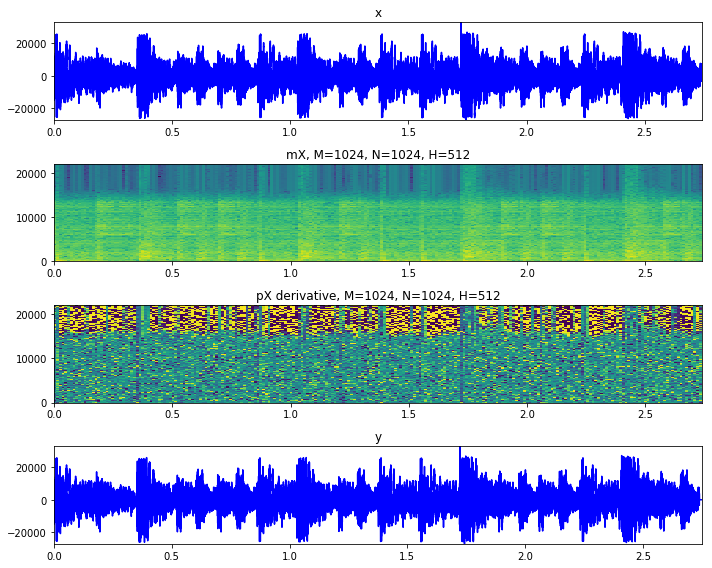

In [12]:
y = plot_stft_analysis(samples)

We can see that original signal and the one reconstructed via a STFT -> ISTSF transform look identical.  Let's confirm they sound identical, too:

**Original**

In [13]:
from NoteSequence import render_samples_ipython
render_samples_ipython(samples)

**Transformed with STFT -> ISTSF **

In [14]:
render_samples_ipython(y)

## Morphing Spectra with the STFT

Now that we have a representation that combines the time and frequency domains, we can make transformations betwee the analysis and synthesis (STFT and ISTFT) phases, manipulating the frequency domain over time directly.

For example, we can morph the sprectra of two different signals over time.

In the following example, the sound of an orchestra gradually has its spectrum mixed together with the spectrum of a section of male speech. In this way we can start to mix _timbres_ of sounds, among many other applications.

_(This is taken directly from the [Audio Signal Processing](https://github.com/MTG/sms-tools/blob/master/software/transformations/stftTransformations.py) [course lectures](https://github.com/MTG/sms-tools/blob/master/lectures/08-Sound-transformations/plots-code/stftMorph-orchestra.py))_.

In [15]:
from scipy.signal import resample

def stftMorph(x1, x2, w1, N1, w2, N2, H1, smoothf, balance_begin, balance_end):
    M1 = w1.size
    hM1_1 = (M1+1) // 2
    hM1_2 = M1 // 2
    L = int(x1.size/H1)
    balances = np.linspace(balance_begin, balance_end, L)
    x1 = np.append(np.zeros(hM1_2),x1)
    x1 = np.append(x1,np.zeros(hM1_1))
    pin1 = hM1_1
    w1 = w1 / np.sum(w1)
    M2 = w2.size
    hM2_1 = (M2+1) // 2
    hM2_2 = M2//2
    H2 = int(x2.size/L)
    x2 = np.append(np.zeros(hM2_2),x2)
    x2 = np.append(x2,np.zeros(hM2_1))
    pin2 = hM2_1
    y = np.zeros(x1.size)
    for l in range(L):
        #-----analysis-----  
        mX1, pX1 = dft(x1[pin1-hM1_1:pin1+hM1_2], w1, N1)
        mX2, pX2 = dft(x2[pin2-hM2_1:pin2+hM2_2], w2, N2)
        #-----transformation-----
        mX2smooth = resample(np.maximum(-200, mX2), int(mX2.size*smoothf))
        mX2 = resample(mX2smooth, mX1.size)
        mY = balances[l] * mX2 + (1-balances[l]) * mX1
        #-----synthesis-----
        y[pin1-hM1_1:pin1+hM1_2] += H1*idft(mY, pX1, M1)
        pin1 += H1
        pin2 += H2
    y = np.delete(y, range(hM1_2))
    y = np.delete(y, range(y.size-hM1_1, y.size))
    return y

In [16]:
fs, x1 = readwav('../orchestra.wav')
fs, x2 = readwav('../speech-male.wav')
w1 = np.hamming(1024)
N1 = 1024
H1 = 256
w2 = np.hamming(1024)
N2 = 1024
smoothf = 0.2
y = stftMorph(x1, x2, w1, N1, w2, N2, H1, smoothf, 0, 1)
render_samples_ipython(y)